In [1]:
import pandas as pd
import bqplot
import json
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#Import data, ensure dates render in date format, and check it displays correctly
hurricanes = pd.read_csv('hurricane_data_final.csv',index_col=0, parse_dates=True)
hurricanes['date'] = pd.to_datetime(hurricanes['date'], format='ISO8601')
hurricanes.tail()

,name,year,cyclone_of_the_year,num_of_track_entries,date,time,record_identifier,status_of_system,latitude,longitude,...,34kt_SW,34kt_NW,50kt_NE,50kt_SE,50kt_SW,50kt_NW,64kt_NE,64kt_SE,64kt_SW,64kt_NW
basin,,,,,,,,,,,,,,,,,,,,,
AL,KATE,2015,12,20,2015-11-12,1200,NaN,EX,41.3N,50.4W,...,180.0,120.0,120.0,120.0,60.0,0.0,0.0,0.0,0.0,0.0
AL,KATE,2015,12,20,2015-11-12,1800,NaN,EX,41.9N,49.9W,...,180.0,120.0,120.0,120.0,60.0,0.0,0.0,0.0,0.0,0.0
AL,KATE,2015,12,20,2015-11-13,0,NaN,EX,41.5N,49.2W,...,200.0,220.0,120.0,120.0,60.0,0.0,0.0,0.0,0.0,0.0
AL,KATE,2015,12,20,2015-11-13,600,NaN,EX,40.8N,47.5W,...,180.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL,KATE,2015,12,20,2015-11-13,1200,NaN,EX,40.7N,45.4W,...,150.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


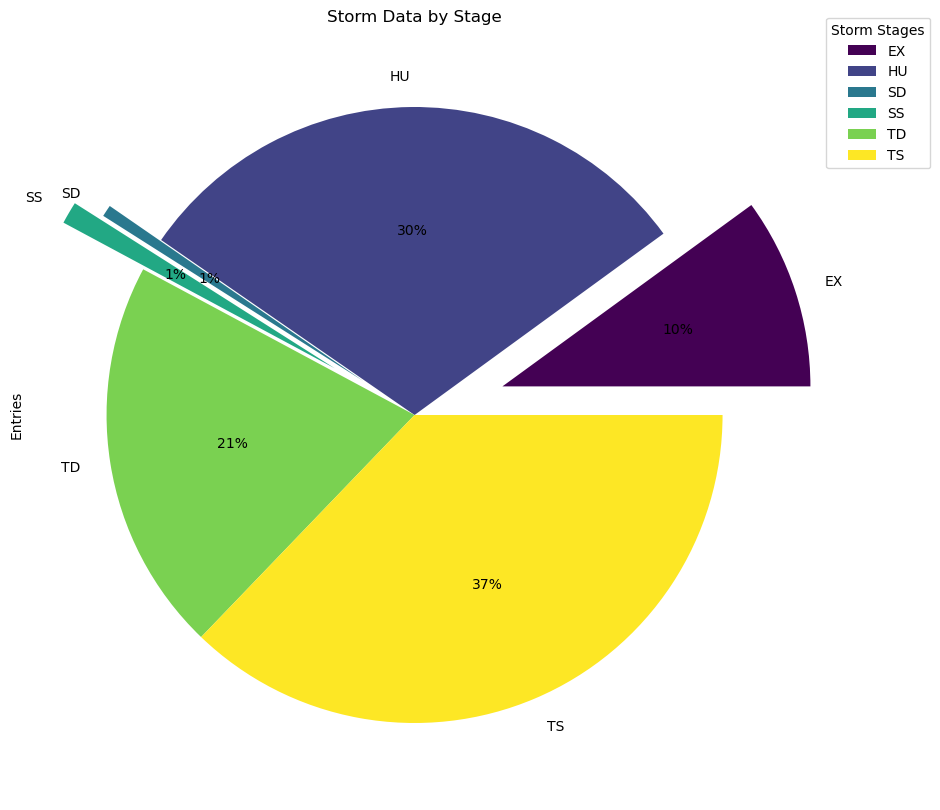

In [3]:
#From NOAA, storms recorded are assigned stages as follows:
#TD – Tropical cyclone of tropical depression intensity (< 34 knots)
#TS – Tropical cyclone of tropical storm intensity (34-63 knots)
#HU – Tropical cyclone of hurricane intensity (> 64 knots)
#EX – Extratropical cyclone (of any intensity)
#SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
#SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)

#Let's create a pie chart to show what percentage of the data in this dataset belongs to each of these respective stages:

grouped_systems = hurricanes.groupby(['status_of_system']).size().reset_index(name='Entries')
storm_stages = ['TD', 'TS', 'HU', 'EX', 'SD', 'SS']

filtered_systems = grouped_systems[grouped_systems['status_of_system'].isin(storm_stages)]

#bake the pie
explode = (0.3, 0.0, 0.2, 0.3, 0.0, 0.0)
colors = ('#440154FF', '#414487FF', '#2A788EFF',
          '#22A884FF', '#7AD151FF', '#FDE725FF')

filtered_systems.groupby(['status_of_system']).sum().plot(kind='pie', title='Storm Data by Stage', y='Entries', figsize=(10, 10), 
                                                          autopct='%1.0f%%', colors=colors, explode=explode, startangle=0)
plt.legend(title='Storm Stages', bbox_to_anchor=(1.025,1.025), loc='upper left')

In [4]:
#Filter hurricanes for only named data
substring = 'UNNAMED'
filter = hurricanes['name'].str.contains(substring)
filtered_hurricanes = hurricanes[~filter]

#Find the average sustained wind speed for named storms occurring in 1994 and make a new dataframe for that data
hurricanes94 = filtered_hurricanes.loc[(filtered_hurricanes['year'] == 1994)]
mean_wind = hurricanes94.groupby('name')['max_sustained_wind'].mean().round(1).reset_index(name='average_sustained_winds')
mean_wind

,name,average_sustained_winds
0,ALBERTO,27.2
1,BERYL,26.2
2,CHRIS,48.7
3,DEBBY,46.2
4,ERNESTO,33.6
5,FLORENCE,59.6
6,GORDON,39.9


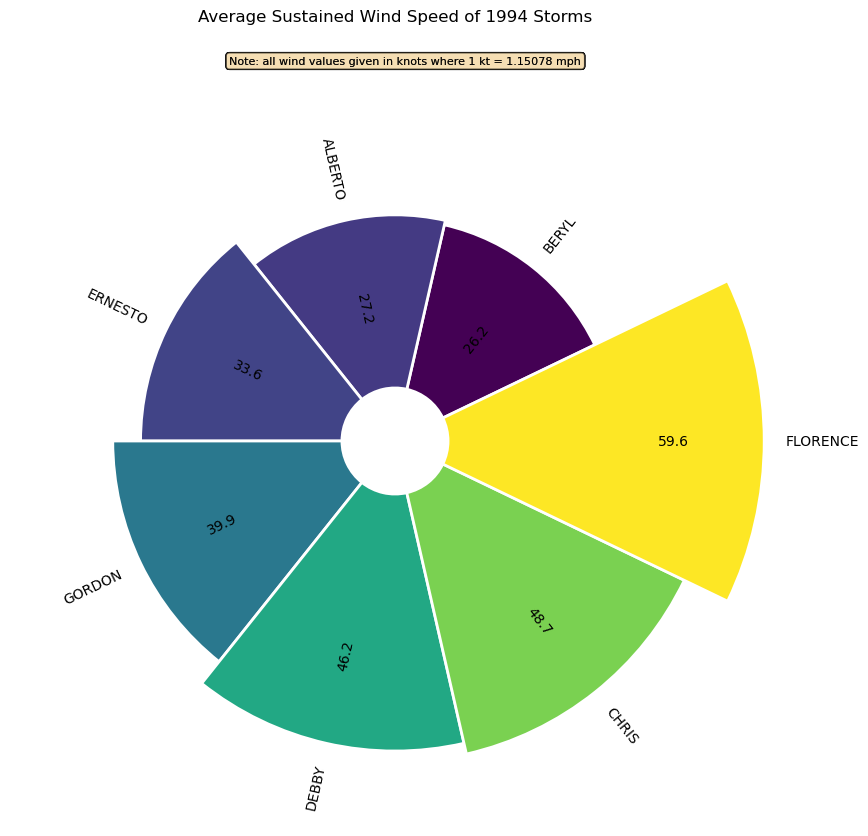

In [5]:
#Sort the values in the new df by average sustained wind speed
mean_wind_sorted = mean_wind.sort_values(by=['average_sustained_winds'])

#intialize and create the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')
plt.title('Average Sustained Wind Speed of 1994 Storms')

upperLimit = 75
lowerLimit = 10
labelPadding = 4
labelPadding2 = -20

#compute the height, width, and angle of each data point based on the column 'average_sustained_winds'
max = mean_wind_sorted['average_sustained_winds'].max()
slope = (max - lowerLimit) / max
heights = slope * mean_wind_sorted.average_sustained_winds + lowerLimit
width = 2*np.pi / len(mean_wind_sorted.index)
indexes = list(range(1, len(mean_wind_sorted.index)+1))

angles = [element * width for element in indexes]
angles

#format visual colors and draw bars
colors = ('#440154FF', '#443A83FF', '#414487FF', '#2A788EFF',
          '#22A884FF', '#7AD151FF', '#FDE725FF')
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor='white',
    color=colors,
)

#add your labels
for bar, angle, height, label1, label2 in zip(bars,angles, heights, mean_wind_sorted['name'],
                                             mean_wind_sorted['average_sustained_winds']):

    #labels are rotated
    rotation = np.rad2deg(angle)

    alignment = ''
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = 'right'
        rotation = rotation + 180
    else: 
        alignment = 'left'

    #the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label1,
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode='anchor') 
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding2, 
        s=label2,
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode='anchor') 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.285, 1.0, 'Note: all wind values given in knots where 1 kt = 1.15078 mph', transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    